## Machine Learning - Desafío 9, Boosting Classifiers
#### Gustavo Morales, G10 - 03.Feb.2020, (Lunes Semana 5)

### **Ejercicio 1: Preprocesamiento**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from itertools import islice

In [2]:
df = pd.read_csv('churn_train.csv').drop(columns='Unnamed: 0')

In [3]:
df.sample(5, random_state=42)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
438,WY,113,area_code_510,no,no,0,155.0,93,26.35,330.6,106,28.10,189.4,123,8.52,13.5,3,3.65,1,no
2674,IL,67,area_code_415,no,no,0,109.1,117,18.55,217.4,124,18.48,188.4,141,8.48,12.8,6,3.46,0,no
1345,SD,98,area_code_415,no,no,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4,yes
1957,KY,147,area_code_408,no,no,0,212.8,79,36.18,204.1,91,17.35,156.2,113,7.03,10.2,2,2.75,1,no
2148,WY,96,area_code_408,no,no,0,144.0,102,24.48,224.7,73,19.10,227.7,91,10.25,10.0,7,2.70,1,no


In [4]:
df.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Columns: 20 entries, state to churn
dtypes: float64(8), int64(7), object(5)
memory usage: 520.9+ KB


**Comportamiento distributivo:**

In [5]:
df_num = df.select_dtypes(exclude=['object'])
df_obj = df.select_dtypes(include=['object'])

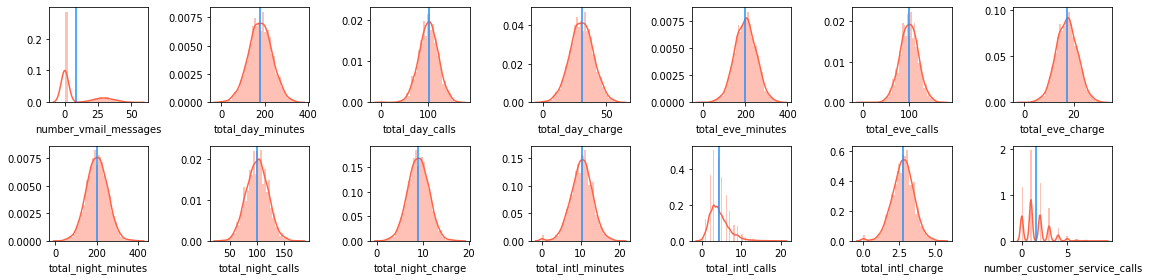

In [6]:
plt.rcParams['figure.figsize'] = 16, 4
for i, var in enumerate(df_num.columns.tolist()[1:]):
    plt.subplot(2,7,i+1)
    sns.distplot(df_num[var], color='tomato', kde=True)
    plt.axvline(df_num[var].mean(), color='dodgerblue')
    plt.grid(False)
plt.tight_layout()

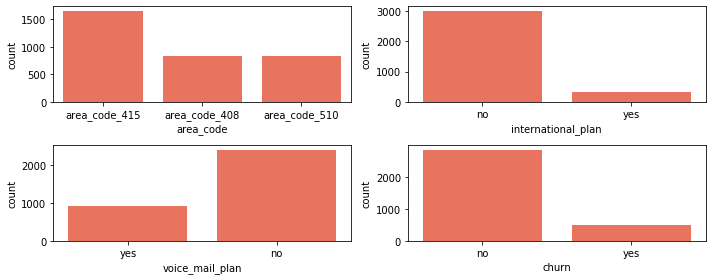

In [7]:
plt.rcParams['figure.figsize'] = 10, 4
for i, var in enumerate(df_obj.columns.tolist()[1:]):
    plt.subplot(2,2,i+1)
    sns.countplot(df_obj[var], color='tomato')
    plt.grid(False)
plt.tight_layout()

**(R)** En general los atributos tienen una distribución normal, con excepción de:

- `number_vmail_messages`,
- `total_intl_calls`, y
- `number_customer_service_calls`.

**Recodificación de variables categóricas:**

In [8]:
cols_to_delete = []
for col in df:
    if df[col].dtype == 'object':
        df = pd.concat([df, pd.get_dummies(df[col], drop_first=True, prefix=col)], axis=1)
        cols_to_delete.append(col)
df_dummy = df.drop(columns=cols_to_delete)

**Transformación de variables numéricas con alto sesgo:**

In [9]:
hvar_vars = ['number_vmail_messages', 'number_customer_service_calls', 'total_intl_calls']
for i in hvar_vars:
    df_dummy[i] = df_dummy[i].apply(lambda x: np.log1p(x))

In [10]:
df = df_dummy

### **Ejercicio 2: Comparación de AdaBoost y Gradient Boosting**

In [11]:
X = df.drop(['churn_yes'], axis=1)
y = df['churn_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

**AdaBoost:**

In [12]:
CV = 2
VERBOSITY = 1
PARAM_GRID_ADA = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 500, 1000, 2000]
}

grid_ada = GridSearchCV(AdaBoostClassifier(random_state=42),
                        param_grid=PARAM_GRID_ADA,
                        cv=CV, verbose=VERBOSITY).fit(X_train, y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


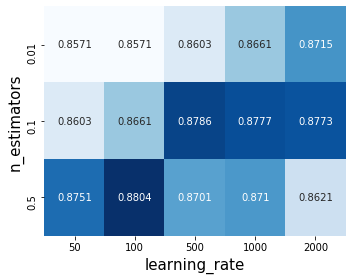

In [13]:
scores = grid_ada.cv_results_['mean_test_score']
data = scores.reshape(len(PARAM_GRID_ADA['learning_rate']),len(PARAM_GRID_ADA['n_estimators']))
plt.figure(figsize=(5,4))
sns.heatmap(
    data, cmap='Blues', annot=True, fmt='.4', cbar=False,
    xticklabels=PARAM_GRID_ADA['n_estimators'],
    yticklabels=PARAM_GRID_ADA['learning_rate']
)
plt.xlabel('learning_rate', fontsize=15)
plt.ylabel('n_estimators', fontsize=15)
plt.tight_layout()

In [14]:
data

array([[0.85714223, 0.85714223, 0.86027482, 0.86609879, 0.87147192],
       [0.86027482, 0.86609919, 0.87863637, 0.87774032, 0.87729349],
       [0.87505535, 0.88043049, 0.87012784, 0.8710243 , 0.86206653]])

In [15]:
print(grid_ada.best_params_)

{'learning_rate': 0.5, 'n_estimators': 100}


In [16]:
grid_ada_pred = grid_ada.predict(X_test)

In [17]:
print(classification_report(y_test, grid_ada_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       940
           1       0.68      0.31      0.43       160

    accuracy                           0.88      1100
   macro avg       0.79      0.64      0.68      1100
weighted avg       0.86      0.88      0.86      1100



**(R)** Promedio ponderado del _F1 score_ de 86%, y _accuracy_ 88%.

**Gradient Boosting:**

In [18]:
CV = 2
VERBOSITY = 1
PARAM_GRID_GRA = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 500, 1000, 2000],
    'subsample': [0.1, 0.5, 0.9]
}

grid_gra = GridSearchCV(GradientBoostingClassifier(random_state=42),
                        param_grid=PARAM_GRID_GRA,
                        cv=CV, verbose=VERBOSITY).fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.2min finished


In [19]:
print(grid_gra.best_params_)

{'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9}


In [20]:
grid_gra_pred = grid_gra.predict(X_test)

In [21]:
print(classification_report(y_test, grid_gra_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       940
           1       0.93      0.72      0.81       160

    accuracy                           0.95      1100
   macro avg       0.94      0.85      0.89      1100
weighted avg       0.95      0.95      0.95      1100



**(R)** Promedio ponderado del _F1 score_ de 95%, y _accuracy_ 95%. Es el modelo que tiene mejor rendimiento.

### **Ejercicio 3: Principales factores asociados**

In [22]:
def plot_importance(fit_model, feat_names):
    tmp_importance = fit_model.best_estimator_.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title('Feature importance')
    plt.barh(names[:10], tmp_importance[sort_importance][:10])
    plt.yticks(names[:10], names, rotation = 0)

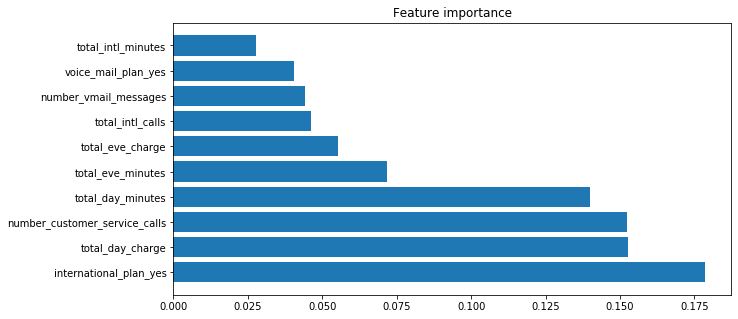

In [23]:
plt.rcParams['figure.figsize'] = 10, 5
plot_importance(grid_gra, X.columns)

**Atributos que aumentan de mayor manera la probabilidad de fuga:**
* `international_plan_yes`: Tener plan internacional.
* `total_day_charge`: Cobros realizados en la mañana.
* `number_customer_service_calls`: Número de llamadas de servicio al cliente.

### **Ejercicio 4: Probabilidad de fuga**

In [24]:
df_test = pd.read_csv('churn_test.csv').drop(columns='Unnamed: 0')

In [25]:
df_test.sample(5, random_state=42)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
940,WY,142,area_code_408,no,yes,34,219.5,85,37.32,144.0,120,12.24,258.2,84,11.62,7.0,3,1.89,1,no
987,KY,94,area_code_408,no,no,0,139.1,93,23.65,237.9,100,20.22,227.1,59,10.22,11.4,3,3.08,1,no
405,NJ,91,area_code_415,no,no,0,93.5,110,15.90,213.3,79,18.13,171.7,83,7.73,8.9,4,2.40,4,yes
721,AL,42,area_code_510,no,no,0,160.2,103,27.23,159.8,116,13.58,255.7,87,11.51,12.9,3,3.48,1,no
1612,ID,57,area_code_415,no,no,0,217.1,115,36.91,258.6,92,21.98,173.7,117,7.82,12.6,6,3.40,2,no


In [26]:
df_test.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Columns: 20 entries, state to churn
dtypes: float64(8), int64(7), object(5)
memory usage: 260.6+ KB


In [27]:
cols_to_delete = []
for col in df_test:
    if df_test[col].dtype == 'object':
        df_test = pd.concat([df_test, pd.get_dummies(df_test[col], drop_first=True, prefix=col)], axis=1)
        cols_to_delete.append(col)
df_test_dummy = df_test.drop(columns=cols_to_delete)

In [28]:
df_test_dummy.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Columns: 70 entries, account_length to churn_yes
dtypes: float64(8), int64(7), uint8(55)
memory usage: 285.0 KB


In [29]:
df = df_test_dummy

In [30]:
X = df.drop(['churn_yes'], axis=1)
y = df['churn_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [31]:
grid_gra_test = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid=PARAM_GRID_GRA,
                             cv=CV, verbose=VERBOSITY).fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


In [32]:
grid_gra_test_pred_proba = grid_gra.best_estimator_.predict_proba(X_test)

In [33]:
import warnings
warnings.simplefilter('ignore')
temp_prob = grid_gra.best_estimator_.predict_proba(X_test)
predicted_proba = X_test.filter(regex='state_*', axis=1)
predicted_proba['pr_0'] = [i[0] for i in temp_prob]
predicted_proba['pr_1'] = [i[1] for i in temp_prob]

In [34]:
d = {state:predicted_proba[predicted_proba[state]==1]['pr_1'].mean() for (state,_) in predicted_proba.iteritems()}
d = {k:v for k,v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

In [35]:
list(islice(d, 3))

['state_CT', 'state_AZ', 'state_NM']

**(R)** Los tres estados con una mayor probabilidad de fuga están dados por **Connecticut**, **Arizona**, y **New Mexico**.

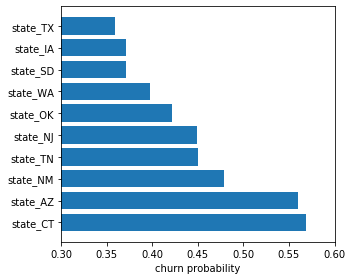

In [36]:
TOP = 10
plt.rcParams['figure.figsize'] = 5, 4
plt.barh(range(len(d))[:TOP], list(d.values())[:TOP])
plt.yticks(range(len(d))[:TOP], list(d.keys())[:TOP], rotation=0)
plt.xlim([0.3,0.6])
plt.xlabel('churn probability')
plt.tight_layout()